In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn import metrics

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_array

from scipy import optimize
from scipy import spatial

sns.set_style('darkgrid')

# Physics-Based Learning Models for Ship Hydrodynamics

To illustrate the basic ideas and efficacy of PBLM, consider a simple model problem of the transient startup from rest of the resonant harmic motions, say corresponding to initial development of the resonant response of a floating body in regular waves. For simplicity, we assume the true motion is given by

$$
f(t) = \alpha tanh(\beta t)sin(\omega t + \phi)
$$

In [2]:
beta = 3
omega = 8*np.pi
alpha = 1
phi = 0.15*np.pi

def f(t):
    return alpha*np.tanh(beta*t)*np.sin(omega*t + phi)

var = np.var(f(np.linspace(0, 1, 1000)))

def noisy_f(x, percent=0.1):
    f_x = f(x)
    v = (percent**2*var)
    np.random.seed(4)
    return f(x)+np.random.normal(0, scale=v, size=x.shape)

(0.0, 1.0)

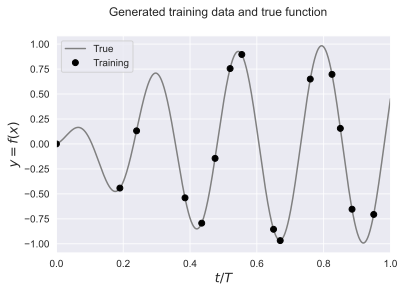

In [3]:
X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
y_test = f(X_test)[:, 0]
X_train = np.array([0, 0.19, 0.24, 0.385, 0.435, 0.475, 0.52, 0.555, 0.65, 0.67, 0.76, 0.825, 0.85, 0.885, 0.95])#np.random.uniform(0, 1, N).reshape(-1, 1)#np.linspace(0, np.pi, 10, 'o').reshape(-1, 1)
X_train = np.atleast_2d(X_train).T
y_train = noisy_f(X_train)[:, 0]

#N = 12
#X_train = np.random.choice(t.reshape(-1), size=N).reshape(-1, 1)
#y_train = f(X_train) + np.random.normal(0, scale=0.05, size=(N, 1))

fig, ax = plt.subplots()
ax.plot(X_test, f(X_test), 'grey', label="True")
#ax.plot(X_test, y_test, 'g.', alpha=.1, label="True+Noise")
ax.plot(X_train, y_train, 'ko', label="Training")
ax.set_xlabel(r'$t/T$', fontsize=13)
ax.set_ylabel(r'$y = f(x)$', fontsize=13)
ax.legend()
fig.suptitle("Generated training data and true function")
ax.set_xlim(0, 1)

# Gaussian regularization network

Non-parametric methods use a generic learning function of the form

$$
f_\mathcal{G}(\mathbf{x}|\mathbf{c}) = \sum_{i=1}^{n}c_iG(\mathbf{x}-\mathbf{x_i}) = \sum_{i=1}^{n}c_i\gamma_i(x)
$$

Where G is a symmetric kernel function which is used to generate a generic basis function $\gamma_i$ for every data point $\mathbf{x_i}$. Unlike a polynomial basis, these kernels are localized, e.g., A Gaussian kernel $G(\mathbf(x)) = exp(||\mathbf{x}||^2/\sigma)$, limiting the influence of each basis function to a subregion of the input space. This enables the non-parametric model to accurately fit the training data from a wide variety of systems. However, non-parametric models have up to n degrees of freedom which makes them very prone to over-fitting.

In [6]:
def gaussian_kernel(x, xi, sigma=1):
    sq_norm = -0.5*spatial.distance.cdist(x, xi, 'sqeuclidean')
    return np.exp(sq_norm/sigma**2)

class GRN(BaseEstimator, RegressorMixin):
    
    def __init__(self, sigma=1, alpha=0):
        self.sigma = sigma
        self.alpha = alpha
    
    def fit(self, X, y):
        X = np.atleast_2d(X)
        self.X_train = X
        K = gaussian_kernel(X, X, sigma=self.sigma)
        K += self.alpha * np.identity(X.shape[0])
        self.duel_variables = np.linalg.solve(K, y)
        return self
    
    def predict(self, X):
        K = gaussian_kernel(X, self.X_train, sigma=self.sigma)
        y = np.dot(K, self.duel_variables)
        return y

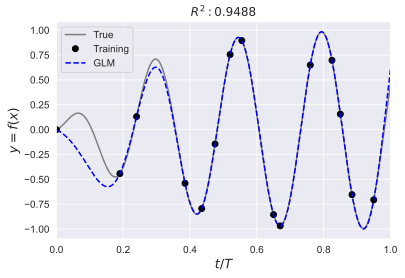

In [25]:
glm = GRN(sigma=0.05, alpha=0.1)
parameters = {
    'alpha':np.linspace(1e-15, 10, 100),
    'sigma':np.linspace(1e-15, 10, 100)
}
cv = GridSearchCV(glm, parameters, cv=5)
cv.fit(X_train, y_train)
glm = cv.best_estimator_
y_pred = glm.predict(X_test)

fig, ax = plt.subplots()
ax.plot(X_test, f(X_test), 'grey', label="True")
ax.plot(X_train, y_train, 'ko', label="Training")
ax.plot(X_test, y_pred, 'b--', label="GLM")
ax.set_xlabel(r'$t/T$', fontsize=13)
ax.set_ylabel(r'$y = f(x)$', fontsize=13)
ax.set_xlim(0, 1)
ax.set_title(f'$R^2: {glm.score(X_test, f(X_test)):.4f}$')
ax.legend()

In [26]:
glm.get_params()

{'alpha': 1e-15, 'sigma': 0.101010101010102}

# Intermediate model

Without additional knowlegde of the motion amplitude or phase, or the time required to reach steady state, we construct an intermediate model (IM) as, say

$$
f_I(t) = t sin(\omega t)
$$

In [12]:
class F_I(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        return self
    def predict(self, X):
        X = check_array(X)
        return X*np.sin(omega*X)
    def finite_difference(self, X, delta=0.01):
        f_x = self.predict(X)
        f_pdx = self.predict(X+delta)
        f_ndx = self.predict(X-delta)
        return np.hstack((f_x, f_pdx, f_ndx))

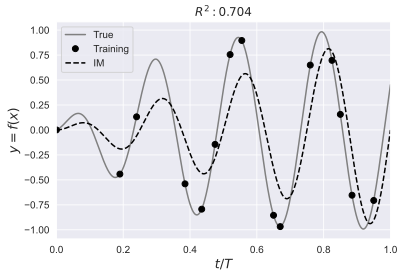

In [14]:
IM = F_I()

fig, ax = plt.subplots()
ax.plot(X_test, f(X_test), 'gray', label='True')
ax.plot(X_train, y_train, 'ko', label="Training")
ax.plot(X_test, IM.predict(X_test), 'k--', label='IM')
ax.set_xlabel(r'$t/T$', fontsize=13)
ax.set_ylabel(r'$y = f(x)$', fontsize=13)
ax.set_xlim(0, 1)
ax.set_title(f'$R^2: {IM.score(X_test, f(X_test)):.3f}$')
ax.legend()

## Linear Additive Model

While the intermediate model has low preditive accuracy, it encapsulates additional knowledge of our system and can beused to improve the GLM prediciton by supplementing the data with this information. We could parametrize $f_I$, turning it into a semi-emperical model. However this approach does not apply to general intermediate models. The simplest way to use the IM as a 'black-box' is to treat the difference between $f_I$ and the data as a nuisance variable and fit that error with a GLM. Taking this idea one step further we can use a linear additive model

$$
f_A(t|\boldsymbol{c}) = f_I(t)c_p + f_g(t|\boldsymbol{c_\gamma})
$$

Which linearly weights the IM predicitons with the GLM predicitons to obtain the best overall fit to the data. The additive model is an improvement over the nuisance model because the physics-based coefficient $c_p$ is determined simultaneously with the generic coefficients $\boldsymbol{c_\gamma}$. 

In [15]:
# to do

## Additive model discussion

While the additive model is a step in the right direction, it is too reliant on the GLM and the accuracy of the function $f_I$. Our solution is to expand the physics-based degrees of freedom into a representative basis using a Taylor expansion of $f_I$ (to provide gradient information). This gives the learning model more information about the form of $f_I$ and more flexability in constructing a physics-based solution before relying on the same generic basis $\gamma$. One of the central advantages of shifting our information burden from the data to the IM is that the IM can be evaluated anywhere very quickly. Not just at the x points where the data is available. Therefore, we can establish the properties of the IM, such as the local derivatives, using a finite difference approximation

$$
\rho(x) = \left(f_I(x), \frac{f_I(x+\Delta x) - f_I(x-\Delta x)}{2\Delta x}, \frac{f_I(x+\Delta x) 2f_I(x) + f_I(x-\Delta x)}{\Delta x^2}, ...\right)
$$

Through linear combinations, the finite difference is equivalent to

$$
\rho(x) = \left(f_I(X), f_I(x+\Delta x), f_I(x-\Delta x)\right)^T
$$

This phase-shifted bases is equivalent to the derivative bases in the limit of $\Delta x \rightarrow 0$. In the cases where phase-shifting either left or right of the data point moves past a physical boundary (such as zero-speed) the offending term is simply left out and the implied derivative reverts to a one-sided first order approximation.

We develop two simple and robust methods of including the phase-shifted physical basis $\rho$ in our PBLM. First, we construct a parametric additive model

## Parametric Additive Model

$$
f_P(x|c) = \rho(x)^Tc_\rho+f_G(x|c_\gamma)
$$

In [16]:
# to do

## Non-Parametric Model

A non-parametric version of the form of (5) can be constructed using $\mathbf{\rho}$ to complement the input space, i.e.,

$$
f_\mathcal{P}(\mathbf{x}|\mathbf{c})=f_\mathcal{G}(\mathbf{z}|\mathbf{c}) = \sum_{i=1}^{n}c_i G(\mathbf{\rho}(\mathbf{x})-\mathbf{\rho}(\mathbf{x}_i))G(\mathbf{x}-\mathbf{x}_i)
$$

where $\mathbf{z}=(\mathbf{x}^T, \mathbf{\rho}(\mathbf{x})^T)^T$. This weighted kernel formulation introduces physical-relevance into the PBLM while utilizing the advantages of localized non-parametric regression. 

In [17]:
class PBLM(BaseEstimator, RegressorMixin):
    
    def __init__(self, IM=None, sigma=1, alpha=0):
        self.sigma = sigma
        self.alpha = alpha
        self.IM = IM
    
    def fit(self, X, y):
        X = np.atleast_2d(X)
        self.X_train = X
        self.rho_train = self.IM.finite_difference(X)
        K = gaussian_kernel(self.rho_train, self.rho_train)*gaussian_kernel(X, X, sigma=self.sigma)
        K += self.alpha * np.identity(X.shape[0])
        self.duel_variables = np.linalg.solve(K, y)
        return self
    
    def predict(self, X):
        rho = self.IM.finite_difference(X)
        K = gaussian_kernel(rho, self.rho_train)*gaussian_kernel(X, self.X_train, sigma=self.sigma)
        y = np.dot(K, self.duel_variables)
        return y

In [ ]:
pblm = PBLM(IM=IM, sigma=1, alpha=0)
parameters = {
    'alpha':np.linspace(1e-15, 10, 100),
    'sigma':np.linspace(1e-15, 10, 100)
}
cv = GridSearchCV(pblm, parameters, cv=5)
cv.fit(X_train, y_train)
pblm = cv.best_estimator_
y_pred = pblm.predict(X_test)

fig, ax = plt.subplots()
ax.plot(X_test, f(X_test), 'grey', label="True")
ax.plot(X_train, y_train, 'ko', label="Training")
ax.plot(X_test, IM.predict(X_test), 'k--', label="IM")
ax.plot(X_test, y_pred, 'r--', label="PBLM")
ax.set_xlabel(r'$t/T$', fontsize=13)
ax.set_ylabel(r'$y = f(x)$', fontsize=13)
ax.set_xlim(0, 1)
ax.set_title(f'$R^2: {pblm.score(X_test, f(X_test)):.4f}$')
ax.legend()